In [1]:
import pybedtools as pbt
import numpy as np
from tqdm import tqdm
import glob
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.7)
    return True

## The objective here is to check whether the expectation scores are higher in g4-chipSeq peaks compared to random peaks and how this compares to G4 motifs detected by QuadParser

### We start by first extracting peak sequences and creating random peaks and saving them

In [30]:
def extract_seq(bed_file, fasta_file, out_name):
    chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
    chrom_wise_intervals = {}
    for chrom in chroms:
        chrom_wise_intervals[chrom] = []
    with open (bed_file) as h:
        for l in h:
            c = l.split('\t')
            if c[0] in chroms:
                chrom_wise_intervals[c[0]].append((int(c[1]), int(c[2])))
    
    sequences = []
    fasta_base_dir ='/home/parashar/scratch/hg19_resource/chromosomes'
    nuc_map = {'A': 'T', 'G': 'C', 'T': 'A', 'C': 'G', 'N': 'N'}
    for chrom in chroms:
        print (chrom)
        chrom_seq = "".join([x.rstrip('\n') for x in
               open("%s/%s.fa" % (fasta_base_dir, chrom)).readlines()[1:]]).upper()
        for span in chrom_wise_intervals[chrom]:
            sequences.append(chrom_seq[span[0]:span[1]])
        clear_output()
    with open(out_name, 'w') as OUT:
        OUT.write("\n".join(sequences))

peaks_bed = pbt.BedTool('./data/chip_seq_g4/rhh_25cyc_BG4_12082015_peaks.narrowPeak').saveas(
    './data/chip_seq_g4/peaks.bed')
random_bed = peaks_bed.shuffle(g='/home/parashar/scratch/hg19_resource/hg19.genome', chrom=True).saveas(
    './data/chip_seq_g4/random_peaks.bed')
extract_seq('./data/chip_seq_g4/peaks.bed',
            '/home/parashar/scratch/hg19_resource/genome.fa', './data/chip_seq_g4/peaks.seq')
extract_seq('./data/chip_seq_g4/random_peaks.bed',
            '/home/parashar/scratch/hg19_resource/genome.fa', './data/chip_seq_g4/random_peaks.seq')

### Lets now calculate the G4Hunter scores of the peaks and random peaks

In [ ]:
! Rscript G4Hunter.r ../data/chip_seq_g4/peaks.seq ../data/chip_seq_g4/peaks_hunter_scores.txt
! Rscript G4Hunter.r ../data/chip_seq_g4/random_peaks.seq ../data/chip_seq_g4/random_peaks_hunter_scores.txt

### Now lets load and the expectation scores and calculate the maximum Expectation scores in each of the G4-Chip and random genomic location of equivalent span

In [5]:
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
chrom_info = [x.rstrip('\n').split('\t') for x in 
              open('/home/parashar/scratch/hg19_resource/hg19.genome').readlines()]
chrom_info = {x[0]: int(x[1]) for x in chrom_info}

peaks_bed = pbt.BedTool('./data/chip_seq_g4/peaks.bed')
random_bed = pbt.BedTool('./data/chip_seq_g4/random_peaks.bed')

scores = []
random_scores = []

for chrom in chroms:
    exp_s = np.zeros(chrom_info[chrom])
    for strand in ['positive', 'negative']:
        scores_dir = './data/quad_graph_single_base_scores/%s/%s/*_exp_score.npy' % (
            chrom, strand)
        for fn in tqdm(glob.glob(scores_dir), desc="%s %s" % (chrom, strand)):
            exp = np.load(fn)
            if exp.shape[0] > 1:
                e_indices = np.array(exp[:, 0], dtype=int)
                e_scores = np.array(exp[:, 1], dtype=float)
                exp_s[e_indices] += e_scores
    for i in peaks_bed:
        c = str(i).rstrip('\n').split('\t')
        if c[0] == chrom:
            scores.append(max(exp_s[int(c[1]):int(c[2])]))
    for i in random_bed:
        c = str(i).rstrip('\n').split('\t')
        if c[0] == chrom:
            random_scores.append(max(exp_s[int(c[1]):int(c[2])]))
    clear_output()
scores = np.array(scores)
random_scores = np.array(random_scores)
np.save('./data/chip_seq_g4/peaks_exp_scores', scores)
np.save('./data/chip_seq_g4/peaks_exp_random_scores', random_scores)

### Now lets calculate the number of G4 motifs of various configurations that occur in Peaks and random regions

In [5]:
g4_base_dir = '/home/parashar/scratch/quadruplexes/hg19'

peak_motifs = []
random_motifs = []
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
chrom_info_file = '/home/parashar/scratch/hg19_resource/hg19.genome'
chrom_info = [x.rstrip('\n').split('\t') for x in
              open(chrom_info_file).readlines()]
chrom_info = {x[0]: (0, int(x[1])) for x in chrom_info}

peaks_bed = pbt.BedTool('./data/chip_seq_g4/peaks.bed').set_chromsizes(chrom_info)
# random_peaks = pbt.BedTool('./data/chip_seq_g4/random_peaks.bed')
for chrom in chroms:
    chrom_wise = []
    chrom_wise_random = []
    for bulge in [0, 3]:
        for loop in [3, 15]:
            print (chrom, loop, bulge)
            g4_motifs = pbt.BedTool('%s/g3_%s_%s_%s_nov.bed' % (g4_base_dir, loop, bulge, chrom))
            chrom_wise.append(peaks_bed.intersect(g4_motifs, u=True).count())
            # chrom_wise.append(random_peaks.intersect(g4_motifs, u=True).count())
            chrom_wise_random.append(np.mean(list(
                        peaks_bed.randomintersection(g4_motifs, iterations=10, processes=15,
                                                     shuffle_kwargs={'chrom': False})
            )))
            clear_output()
    peak_motifs.append(list(chrom_wise))
    random_motifs.append(list(chrom_wise_random))

peak_motifs = np.array(peak_motifs)
random_motifs = np.array(random_motifs)

np.save('./data/chip_seq_g4/peaks_motifs', peak_motifs.sum(axis=0))
np.save('./data/chip_seq_g4/random_peaks_motifs', random_motifs.sum(axis=0))

### Time to plot data

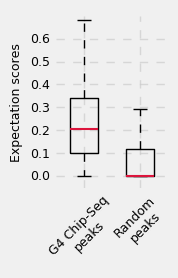

MannwhitneyuResult(statistic=74376725.5, pvalue=0.0)

In [12]:
peak_exp = np.load('./data/chip_seq_g4/peaks_exp_scores.npy')
random_exp = np.load('./data/chip_seq_g4/peaks_exp_random_scores.npy')

fig, ax = plt.subplots(1, 1, figsize=(2, 3))

boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([peak_exp, random_exp], sym='', widths=[0.5, 0.5],
           boxprops=boxprops, 
           medianprops=medianprops, whiskerprops=whiskerprops)
ax.set_ylim((-0.05, 0.7))
ax.set_ylabel('Expectation scores', fontsize=9)
ax.set_xticklabels(['G4 Chip-Seq\npeaks', 'Random\npeaks'], rotation=45, fontsize=9)
clean_axis(ax)

plt.tight_layout()
plt.savefig('g4_chip_seq_exp_scores.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('g4_chip_seq_exp_scores.svg', transparent=True, edgecolor='none')
plt.show()
mannwhitneyu(peak_exp, random_exp)

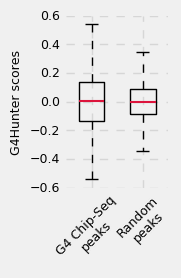

MannwhitneyuResult(statistic=178480541.5, pvalue=0.02945673599491563)

In [12]:
def load_hunter(fn):
    s = []
    with open(fn) as h:
        next(h)
        for l in h:
            c = l.rstrip('\n').split('\t')
            s.append(float(c[1]))
    return np.array(s)

peak_hunter_scores = load_hunter('./data/chip_seq_g4/peaks_hunter_scores.txt')
random_peaks_hunter_scores = load_hunter('./data/chip_seq_g4/random_peaks_hunter_scores.txt')

fig, ax = plt.subplots(1, 1, figsize=(2, 3))

boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([peak_hunter_scores, random_peaks_hunter_scores], sym='', widths=[0.5, 0.5],
           boxprops=boxprops, 
           medianprops=medianprops, whiskerprops=whiskerprops)
#ax.set_ylim((-0.05, 0.7))
ax.set_ylabel('G4Hunter scores', fontsize=9)
ax.set_xticklabels(['G4 Chip-Seq\npeaks', 'Random\npeaks'], rotation=45, fontsize=9)
clean_axis(ax)

plt.tight_layout()
plt.savefig('g4_chip_seq_hunter_scores.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('g4_chip_seq_hunter_scores.svg', transparent=True, edgecolor='none')
plt.show()
mannwhitneyu(peak_hunter_scores, random_peaks_hunter_scores)

In [2]:
peak_motifs = np.load('./data/chip_seq_g4/peaks_motifs.npy')
random_motifs = np.load('./data/chip_seq_g4/random_peaks_motifs.npy')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 2.5))

boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([peak_exp, random_exp], sym='', widths=[0.5, 0.5],
           boxprops=boxprops, 
           medianprops=medianprops, whiskerprops=whiskerprops)
ax.set_ylim((-0.05, 0.7))
ax.set_ylabel('Expectation scores', fontsize=9)
ax.set_xticklabels(['G4 Chip-Seq\npeaks', 'Random\npeaks'], rotation=45, fontsize=9)
clean_axis(ax)
plt.show()
mannwhitneyu(scores, random_scores)

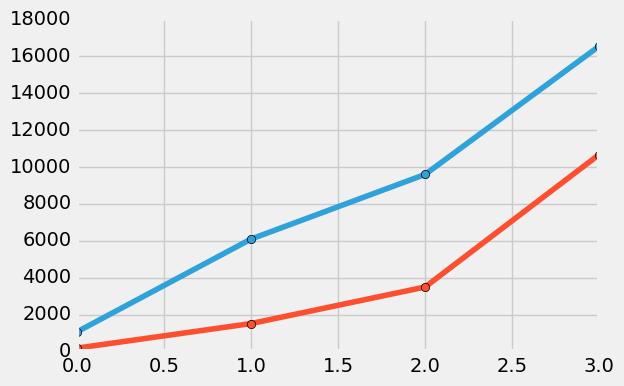

In [5]:
plt.plot(peak_motifs, '-o')
plt.plot(random_motifs, '-o')
plt.show()


In [6]:
peak_motifs

array([ 1064,  6094,  9596, 16549])

In [7]:
random_motifs

array([   180.3,   1512.2,   3492.6,  10671.5])